In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import glob 
from gradient_free_optimizers import RandomSearchOptimizer

In [5]:
f = "..//data2//random, difficulty 50 Mon Dec 13 13-44-40 2021.json"

d1 = json.load(open(f))
for k, v in d1.items(): 
    d1[k] = np.array(v)

d1["filename"] = f
d1["difx"] = d1["txs"] - d1["cxs"]
d1["dify"] = d1["tys"] - d1["cys"]


print("r(dx, Tx)=", np.corrcoef(d1["difx"], d1["txs"])[0,1])
print("r(dy, Ty)=", np.corrcoef(d1["dify"], d1["tys"])[0,1])

print("r(Cx, Tx)=", np.corrcoef(d1["cxs"], d1["txs"])[0,1])
print("r(Cy, Ty)=", np.corrcoef(d1["cys"], d1["tys"])[0,1])


r(dx, Tx)= 0.047084788049421775
r(dy, Ty)= 0.040392792995782335
r(Cx, Tx)= 0.9596178512094669
r(Cy, Ty)= 0.9552621115720951


In [3]:
colors = {
    "target": "#882255",
    "cursor": "#44AA99",
    "model" : "#FE6100"
}

In [4]:
#from numba import njit, jit


#@njit
def rmse(a, b):
    ds = (a - b)**2
    return np.sqrt(np.mean(ds))


#@njit 
def model1delay(qd, qo, K, B, tau, dt):
    """ First order model with delay """
    tauN = round(tau/dt) 
    N = len(qd)
    mc = np.zeros(N)  # model cursor
    mc[0:tauN+1] = qo[0:tau+1]
    for i in range(tauN + 1, N):
        e = 0 - (qd[i-tauN-1] - mc[i-tauN-1])
        mc[i] = mc[i-1] + (K*e - B*mc[i-1]) * dt
    return mc



Results: 'eval_params'  
   Best score: -26.54537752701277  
   Best parameter:
      'K'   : -11.07  
      'B'   : 0.03700000000000081  
      'tau' : 0.11666666666666667  
 
   Evaluation time   : 3.1070985794067383 sec    [90.99 %]
   Optimization time : 0.30756092071533203 sec    [9.01 %]
   Iteration time    : 3.4146595001220703 sec    [4392.82 iter/sec]
 


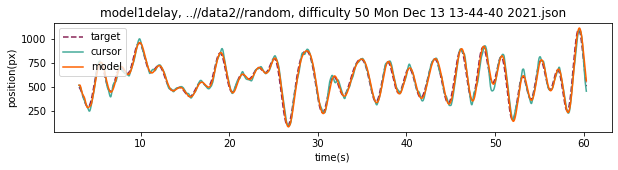


Results: 'eval_params'  
   Best score: -19.807840246655108  
   Best parameter:
      'K'   : -10.22  
      'B'   : -0.01999999999999913  
      'tau' : 0.1  
 
   Evaluation time   : 1.9700088500976562 sec    [86.17 %]
   Optimization time : 0.3160574436187744 sec    [13.83 %]
   Iteration time    : 2.2860662937164307 sec    [6561.49 iter/sec]
 


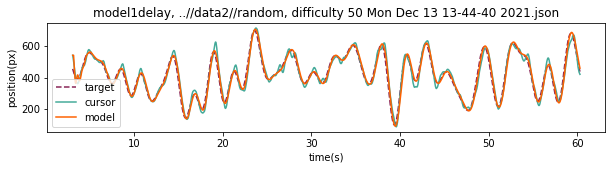

In [5]:
dt = 1.0/60.0

model = {'name': "model1delay",
         'function': model1delay, 
         'params': ['K', 'B', 'tau'], 
         'search_space' :{'K' : np.arange(0.0, -150, -0.01),
                          'B' : np.arange(-1, 1,  0.001),
                          'tau': np.arange(0, 0.250, dt)}, 
        } 


d1['opts'] = {}
for xy in ["x", "y"]:
    qd = d1["t" + xy + "s"][180:]
    qo = d1["c" + xy + "s"][180:]
    ts = d1['tts'][180:]

    def eval_params(p):
        global qd, qo       
        params = [p[name] for name in model['params']]
        m = model['function'](qd, qo, *params, dt)
        score = rmse(qo, m)
        return -score


    opt = RandomSearchOptimizer(model['search_space'])
    opt.search(eval_params, n_iter = 15000)
    d1['opts'][model["name"] + xy] = opt


    m = model['function'](qd, qo, *(list(opt.best_para.values())), dt)

    plt.figure(figsize=[10, 2])
    plt.title(model["name"] + ", " + d1['filename'])
    plt.plot(ts, qd, "--", label="target", color=colors["target"])        
    plt.plot(ts, qo, label="cursor", color=colors["cursor"])
    plt.plot(ts, m, label='model', color=colors["model"])
    plt.legend()
    plt.xlabel("time(s)")
    plt.ylabel('position(px)')
    plt.show()

In [6]:

f2 = "..//data1//tracking agm2 v2 e0.9 beta0.666666  speed 15 2017-02-06 12-07-30.txt"
d2 = json.load(open(f2))
for k, v in d2.items(): 
    d2[k] = np.array(v)
d2["ts"] -= d2["ts"][0]    
dt = 0.005

d2["filename"] = f



In [9]:
from common.trajectory_analysis import Trajectory

params = {'K'   : -10.15, 'B'   : 0.018, 'tau' : 0.100}

files = glob.glob("..//data1//*.txt")
filename_speeds = [     3,    5,    7,    9,   11,   13,   15,   17,   19]
freqs           = [  0.27, 0.40, 0.54, 0.67, 0.81, 0.94, 1.07, 1.21, 1.34]  # Hz

lowpass_cutoff = 10 # Hz
A = np.array
pxtomm = 1/10.8
dt = 0.005
data3 = []
for f in files:
    d = json.load(open(f))
    d["filename"] = f
    ts = A([d["ts"][i] - d["ts"][0] for i in range(len(d["ts"]))])
    tx = d["tx"] = A(d["tx"]) * pxtomm
    ty = d["ty"] = A(d["ty"]) * pxtomm
    cx = d["cx"] = A(d["cx"]) * pxtomm
    cy = d["cy"] = A(d["cy"]) * pxtomm
    
    difx = tx - cx
    dify = ty - cy

    d["r1x"] = np.corrcoef(cx, tx)[0][1]
    d["r2x"] = np.corrcoef(difx, cx)[0][1]
    d["r3x"] = np.corrcoef(difx, tx)[0][1]

    d["r1y"] = np.corrcoef(cy, ty)[0][1]
    d["r2y"] = np.corrcoef(dify, cy)[0][1]
    d["r3y"] = np.corrcoef(dify, ty)[0][1]
        
    d["mx"] = model1delay(tx, cx, **params, dt=dt)
    d["my"] = model1delay(ty, cy, **params, dt=dt)
     
    d["target"] = Trajectory(tx, ty, ts, dt=dt, cut = [0.5, 0.5]).calc_betas()
    d["cursor"] = Trajectory(cx, cy, ts, dt=dt, cut = [0.5, 0.5], smooth=lowpass_cutoff).calc_betas()
    d["model"] = Trajectory(d["mx"], d["my"], ts, dt=dt, cut=[0.5, 0.5]).calc_betas(orthogonal=True)
    
    spi = f.find("speed")
    fn_speed = int(f[spi+5:spi+8])
    fri = filename_speeds.index(fn_speed)
    d["freq"] = freqs[fri]

    data3.append(d)
    


..//data1\tracking agm2 v2 e0.9 beta0.333333  speed 17 2017-02-06 12-06-44.txt


<ipython-input-24-b3afa3d3e2d6>:91: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels(freqs, rotation=25, Fontsize=10)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


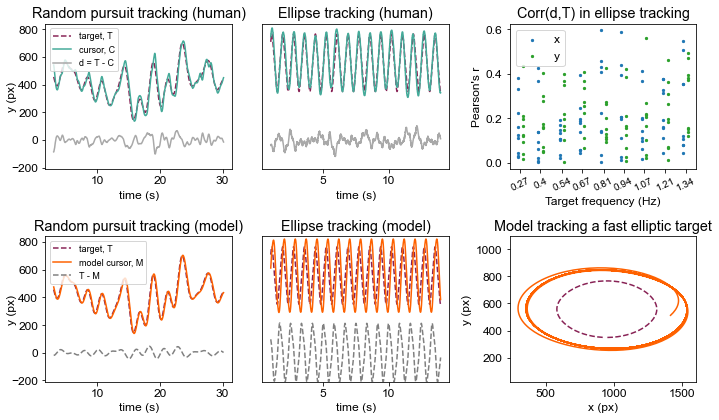

In [24]:
import matplotlib
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 12}
matplotlib.rc('font', **font)

fig, axs = plt.subplots(2,3, figsize=(10.5, 6) )

params = {'K'   : -10.15, 'B'   : 0.018, 'tau' : 0.100}
        
t = d1["tts"]
qo = d1["cys"]
qd = d1["tys"]
dy = d1["dify"]
dt = 1/60

m = model1delay(qd, qo, **params, dt=dt)


take = np.arange(int(3/dt), int(30/dt))




ax = axs[0,0]
ax.set_title("Random pursuit tracking (human)")
ax.plot(t[take], qd[take], "--", color=colors["target"], label="target, T")
ax.plot(t[take], qo[take], color=colors["cursor"], label="cursor, C")
ax.plot(t[take], dy[take], color="darkgray", label="d = T - C")
ax.legend(loc="upper left", prop={'size': 9})
ax.set_xlabel("time (s)")
ax.set_ylabel("y (px)")


ax = axs[1,0]
ax.set_title("Random pursuit tracking (model)")
ax.plot(t[take], qd[take], "--", color=colors["target"], label="target, T")
ax.plot(t[take], m[take], "-", color=colors["model"], label="model cursor, M")
ax.plot(t[take], (qd - m)[take], "--", color="gray", label="T - M" )
ax.legend(loc="upper left", prop={'size': 9})
ax.set_ylabel("y (px)")
ax.set_xlabel("time (s)")

d2 = data3[3]
print(d2["filename"])
t = A(d2["ts"]) - d2["ts"][0]
qo = A(d2["cy"]) / pxtomm
qd = A(d2["ty"]) / pxtomm
dify = qd - qo
dt = 0.005

m = model1delay(qd, qo, **params, dt=dt)

take = np.arange(int(1/dt), int(14/dt))
ax = axs[0, 1]
ax.set_title("Ellipse tracking (human)")

ax.plot(t[take], qd[take], "--", color=colors["target"], label="target, T")
ax.plot(t[take], qo[take], color=colors["cursor"], label="cursor, C")
ax.plot(t[take], dify[take], color="darkgray", label="d = T - C")
ax.set_xlabel("time (s)")
ax.set_yticks([])



ax = axs[1,1]
ax.set_title("Ellipse tracking (model)")
ax.plot(t[take], qd[take], "--", color=colors["target"], label="target, T")
ax.plot(t[take], m[take], "-", color=colors["model"], label="model, M")
ax.plot(t[take], (qd - m)[take], "--", color="gray", label="T - M" )
ax.set_yticks([])
ax.set_xlabel("time (s)")



for ax in [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]:
    ax.set_ylim(-210, 840)

    
r3xs = [abs(d["r3x"]) for d in data3]
r3ys = [abs(d["r3y"]) for d in data3]
freqx = [d["freq"]-0.015 for d in data3] 
freqy = [d["freq"]+0.015 for d in data3] 

ax = axs[0,2]

ax.set_title("Corr(d,T) in ellipse tracking")
ax.scatter(freqx, r3xs, color="tab:blue", label="x", s=5)
ax.scatter(freqy, r3ys, color="tab:green", label="y", s= 5)
ax.set_xticks(freqs)
ax.set_xticklabels(freqs, rotation=25, Fontsize=10)
ax.set_xlabel("Target frequency (Hz)")
ax.set_ylabel("Pearson's r")


ax.legend()

ax = axs[1,2]

d= data3[4]
ax.set_title("Model tracking a fast elliptic target")
ax.plot(d["tx"][:150]/pxtomm, d["ty"][:150]/pxtomm,"--", color=colors["target"], label="target")
ax.plot(d["mx"][60:]/pxtomm, d["my"][60:]/pxtomm, color=colors["model"], label="model")
ax.set_xlabel("x (px)")
ax.set_ylabel("y (px)")
ax.axis("equal")


plt.tight_layout()

for ax in [axs[0,1], axs[1,1]]:
    box = ax.get_position()
    box.x0 += -0.04
    box.x1 += -0.04
    ax.set_position(box)

for ax in [axs[0,2], axs[1,2]]:
    box = ax.get_position()
    box.x0 += -0.04
    box.x1 += -0.04
    ax.set_position(box)

for ax in [axs[0,0], axs[1,0]]:
    ax.yaxis.set_label_coords(-0.15, 0.5);
    
plt.savefig("..//figures//Figure3 Human Model Random Ellipse.eps", format="eps", bbox_inches = "tight")
plt.show()


-0.3330983637631794
-0.33383343566456913
-0.31628849824536415


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


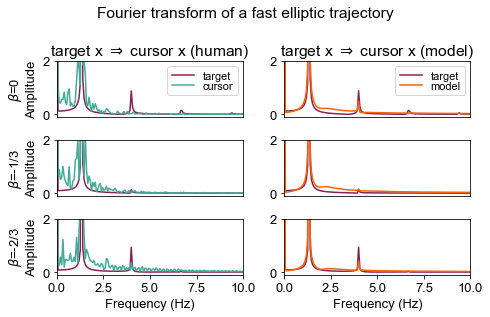

In [20]:
import matplotlib
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 13}

matplotlib.rc('font', **font)

def contains_all(target_string, str_list):
    return all([x in target_string for x in str_list] )
    
fasts = [ d for d in data3 if contains_all(d["filename"], ["speed 19", "am2"])]

fasts.sort(key=lambda x: x["target"].betaCV, reverse=True)

from common.util import fft

fig, axs = plt.subplots(3,2, figsize=(7,4.5))

betas = ["0", "-1/3", "-2/3"]

for i in range(3):
    d = fasts[i] 
    t, c, m = d["target"], d["cursor"], d["model"]
    print(m.betaCV)
    Ftx, Ytx = fft(t.x, 200)
    Fcx, Ycx = fft(c.x, 200)
    Fmx, Ymx = fft(m.x, 200)

    ax = axs[i, 0]
    ax.plot(Ftx, Ytx, "-", color=colors["target"], label ="target")
    ax.plot(Fcx, Ycx, "-", color=colors["cursor"], label ="cursor")
    ax.set_xlim(0, 10)
    ax.set_ylim(-0.1, 2)
    ax.set_ylabel(fr"$\beta$={betas[i]}" "\n"  "Amplitude")

    ax = axs[i, 1]
    ax.plot(Ftx, Ytx, "-", color=colors["target"], label ="target")
    ax.plot(Fmx, Ymx, "-", color=colors["model"], label  ="model")
    ax.set_xlim(0, 10)
    ax.set_ylim(-0.1, 2)

    if  i < 2:
        axs[i,0].set_xticks([])
        axs[i,1].set_xticks([])
        
  

  
axs[2,0].set_xlabel("Frequency (Hz)")
axs[2,1].set_xlabel("Frequency (Hz)")

axs[0,0].legend(prop={'size':11}, labelspacing=0)
axs[0,1].legend(prop={'size':11}, labelspacing=0)

axs[0,0].set_title(r"target x $\Rightarrow$ cursor x (human)")
axs[0,1].set_title(r"target x $\Rightarrow$ cursor x (model)")

plt.suptitle("Fourier transform of a fast elliptic trajectory")
plt.tight_layout()
plt.savefig("..//figures//Figure 3, fourier.eps", format="eps",  bbox_inches = "tight")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


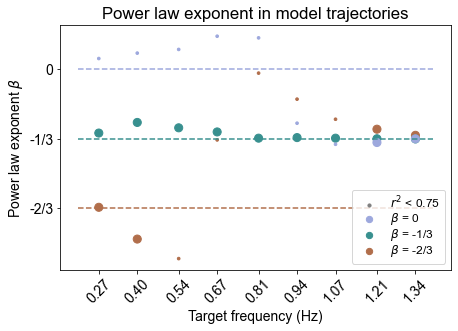

In [23]:
import matplotlib
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 14}

matplotlib.rc('font', **font)

data1 = [d for d in data3 if "am2" in d["filename"]]

freqs_t  = [d["freq"] for d in data1]


beta_colors = ["#9da8dd", "#38908f", "#b16e4B"]

betas  = [d["model"].betaCV for d in data1]
r2s    = [d["model"].r2CV   for d in data1]
tb     = [0 if "beta1" in d["filename"] else 1 if "beta0.6" in d["filename"] else 2 for d in data1]

clrs     = [beta_colors[tb[i]] for i in range(len(r2s))]
sizes    = [65 if r2 >= 0.75 else 7 for r2 in r2s]

plt.figure(figsize=(7, 4.5))


plt.plot([0.2, 1.4], [0, 0], "--", color=beta_colors[0])
plt.plot([0.2, 1.4], [-1/3, -1/3], "--", color=beta_colors[1])
plt.plot([0.2, 1.4], [-2/3, -2/3], "--", color=beta_colors[2])
plt.yticks([0, -1/3, -2/3], ["0", "-1/3", "-2/3"])

plt.scatter(freqs_t, betas, c = clrs, s=sizes)

plt.scatter([], [], c = "gray", s=10, label=r"$r^2$ < 0.75")
plt.scatter([], [], c = beta_colors[0], s=40, label=r"$\beta$ = 0")
plt.scatter([], [], c =  beta_colors[1], s=40, label=r"$\beta$ = -1/3")
plt.scatter([], [], c =  beta_colors[2], s=40, label=r"$\beta$ = -2/3")


plt.xlabel("Target frequency (Hz)")
plt.ylabel(r"Power law exponent $\beta$")
plt.xticks(freqs, rotation = 45)
plt.legend(loc = "lower right", prop={"size":12}, labelspacing=0)
plt.title("Power law exponent in model trajectories")
plt.savefig("..//figures//Figure 3B_ freq_model.eps", format="eps",  bbox_inches = "tight")
plt.show()
